In [1]:
# ===📦 Paket Bawaan===
import os
import random
import shutil
from collections import defaultdict

# ===📊 Data dan Visualisasi===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ===🖼️ Pemrosesan Gambar===
import cv2
from PIL import Image

# ===🤖 TensorFlow & Keras===
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    InputLayer, Input, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D,
    Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import (
    ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
)
from tensorflow.keras.applications import MobileNetV2
from keras.layers import TFSMLayer  # Jika kamu benar-benar butuh ini

# ===🧪 Utilities===
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# ===🌐 Kaggle Hub===
import kagglehub

2025-07-06 05:39:24.441537: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751780364.802459      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751780364.907165      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
path_2 = kagglehub.dataset_download("namanjain001/comprehensive-solid-waste-image-dataset")
path_3 = kagglehub.dataset_download("sumn2u/garbage-classification-v2")

print("Path to dataset files:", path_2)
print("Path to dataset files:", path_3)

Path to dataset files: /kaggle/input/comprehensive-solid-waste-image-dataset
Path to dataset files: /kaggle/input/garbage-classification-v2


In [3]:
print(os.listdir(path_2))
print(os.listdir(path_3))

['Solid_Waste_Dataset']
['garbage-dataset']


In [4]:
print("path 2 class:", os.listdir(os.path.join(path_2, 'Solid_Waste_Dataset')))
print("path 3 class:", os.listdir(os.path.join(path_3, 'garbage-dataset')))

path 2 class: ['Organic_Waste', 'Construction_Waste', 'Electronic_Waste', 'Paper_Cardboard_Waste', 'Metal_Waste', 'Textile_Rubber_Waste', 'Medical_Waste', 'Glass_Waste', 'Plastic_Waste']
path 3 class: ['metal', 'glass', 'biological', 'paper', 'battery', 'trash', 'cardboard', 'shoes', 'clothes', 'plastic']


In [5]:
folder_2 = os.path.join(path_2, 'Solid_Waste_Dataset')
folder_3 = os.path.join(path_3, 'garbage-dataset')

class_names_2 = os.listdir(folder_2)
class_names_3 = os.listdir(folder_3)

print("Class names in folder 2:", class_names_2)
print("Class names in folder 3:", class_names_3)

Class names in folder 2: ['Organic_Waste', 'Construction_Waste', 'Electronic_Waste', 'Paper_Cardboard_Waste', 'Metal_Waste', 'Textile_Rubber_Waste', 'Medical_Waste', 'Glass_Waste', 'Plastic_Waste']
Class names in folder 3: ['metal', 'glass', 'biological', 'paper', 'battery', 'trash', 'cardboard', 'shoes', 'clothes', 'plastic']


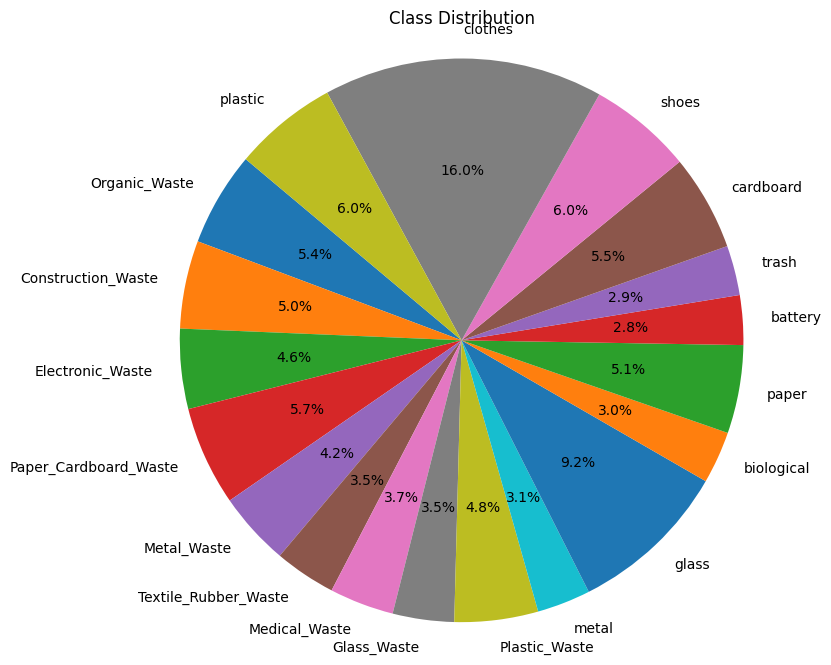

In [7]:
class_counts_dict = defaultdict(int)
for folder in [ folder_2, folder_3]:
    for class_name in os.listdir(folder):
        class_path = os.path.join(folder, class_name)
        if os.path.isdir(class_path):
            class_counts_dict[class_name] += len(os.listdir(class_path))

class_names = list(class_counts_dict.keys())
class_counts = list(class_counts_dict.values())

plt.figure(figsize=(8, 8))
plt.pie(class_counts, labels=class_names, autopct='%1.1f%%', startangle=140)
plt.title('Class Distribution')
plt.axis('equal')  
plt.show()

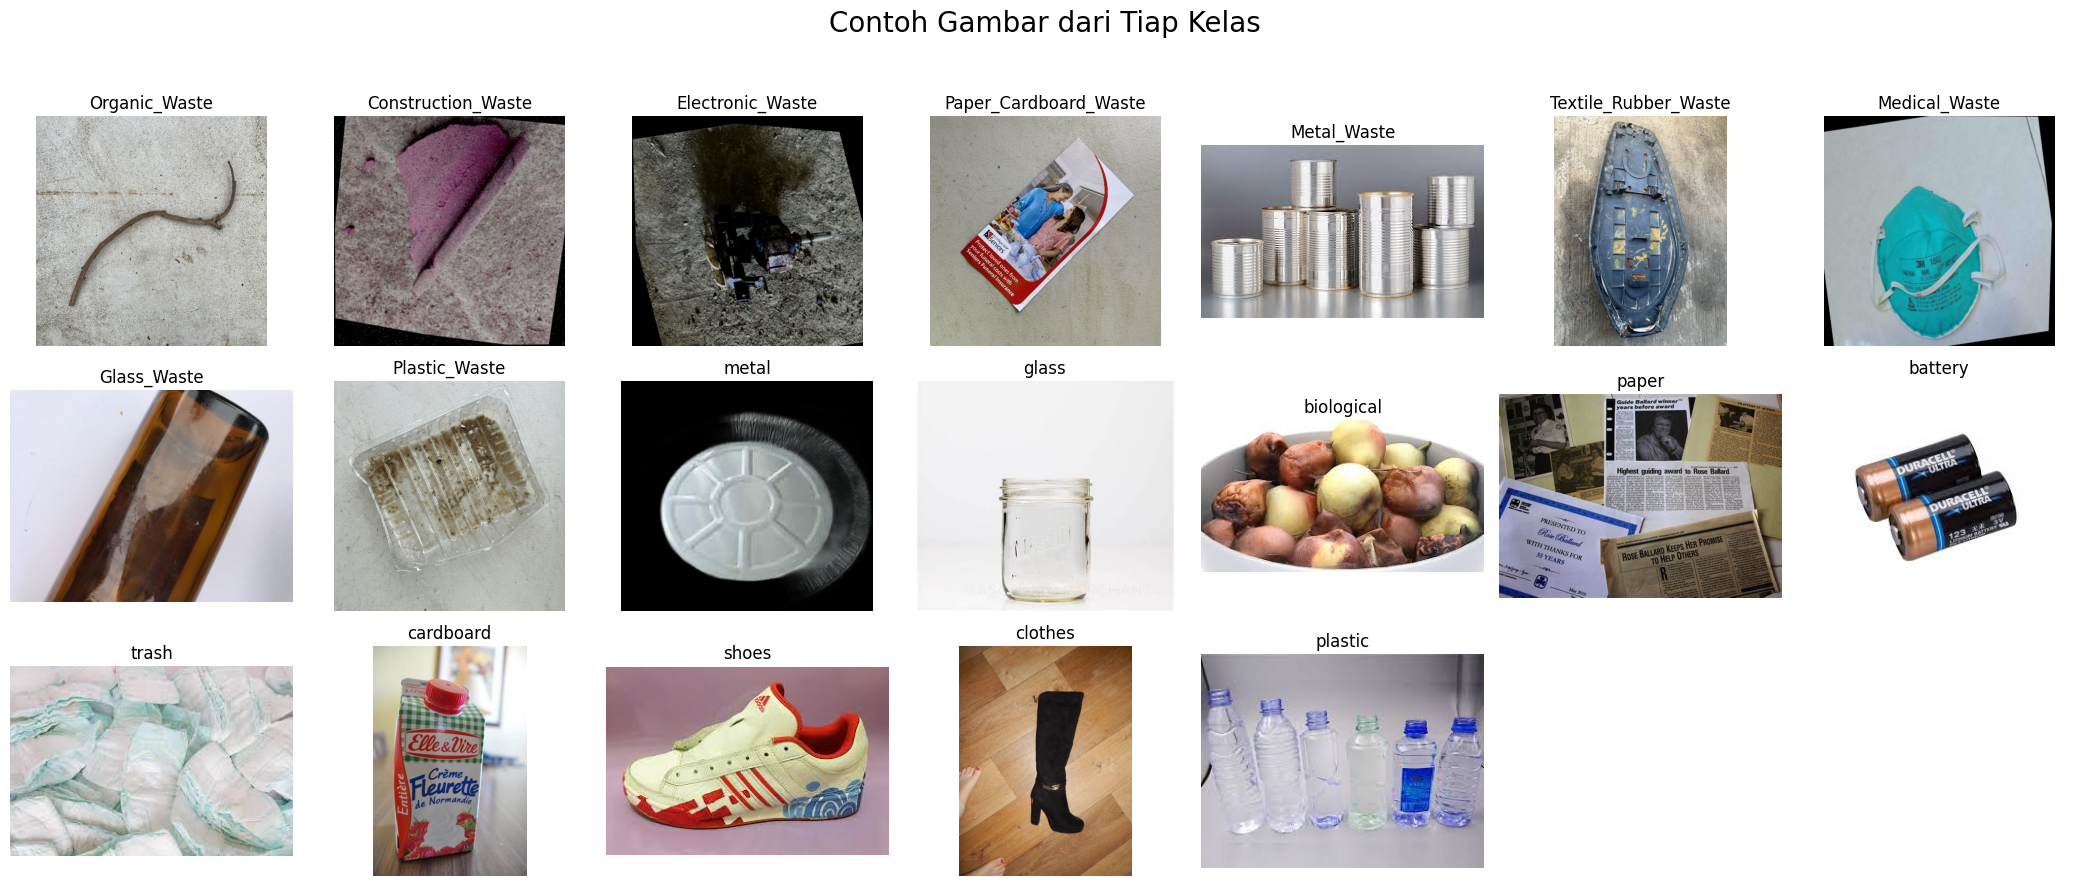

In [8]:
folders = [folder_2, folder_3]

n_classes = len(class_names)
n_rows = 3
n_cols = int(np.ceil(n_classes / n_rows))

fig, axs = plt.subplots(n_rows, n_cols, figsize=(3 * n_cols, 3 * n_rows))
axs = axs.flatten() 

for i, class_name in enumerate(class_names):
    ax = axs[i]
    image_paths = []

    for folder in folders:
        path = os.path.join(folder, class_name)
        if os.path.exists(path):
            image_paths += [os.path.join(path, img) for img in os.listdir(path) if img.lower().endswith(('.jpg', '.png', '.jpeg'))]

    if image_paths:
        img_path = random.choice(image_paths)
        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        ax.imshow(img)
        ax.set_title(class_name)
    else:
        ax.set_title(f"{class_name}\n(no image)")

    ax.axis('off')

for j in range(len(class_names), len(axs)):
    axs[j].axis('off')

plt.suptitle("Contoh Gambar dari Tiap Kelas", fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.95])  
plt.show()

In [9]:
label_to_category = {
    # Limbah B3
    'battery': 'b3',
    'Medical_Waste': 'b3',
    'Electronic_Waste': 'b3',

    # Organik
    'biological': 'organik',
    'Organic_Waste': 'organik',

    # Daur Ulang
    'paper': 'daur_ulang',
    'cardboard': 'daur_ulang',
    'Paper_Cardboard_Waste': 'daur_ulang',
    'plastic': 'daur_ulang',
    'Plastic_Waste': 'daur_ulang',
    'metal': 'daur_ulang',
    'Metal_Waste': 'daur_ulang',
    'glass': 'daur_ulang',
    'white-glass': 'daur_ulang',
    'green-glass': 'daur_ulang',
    'brown-glass': 'daur_ulang',
    'Glass_Waste': 'daur_ulang',

    # Residu
    'trash': 'residu',
    'Construction_Waste': 'residu',
    'Textile_Rubber_Waste': 'residu',
    'shoes': 'residu',   # diasumsikan sintetis
    'clothes': 'residu'  # diasumsikan sintetis
}

In [10]:
source_folders = [ folder_2, folder_3]
target_root = 'dataset_kategori'
os.makedirs(target_root, exist_ok=True)

for new_class in set(label_to_category.values()):
    os.makedirs(os.path.join(target_root, new_class), exist_ok=True)

for source_root in source_folders:
    for old_class, new_class in label_to_category.items():
        old_path = os.path.join(source_root, old_class)
        new_path = os.path.join(target_root, new_class)

        if not os.path.exists(old_path):
            print(f"⚠️ Folder tidak ditemukan: {old_path}")
            continue

        for file in os.listdir(old_path):
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                src = os.path.join(old_path, file)
                prefix = os.path.basename(source_root)
                dst = os.path.join(new_path, f"{prefix}_{old_class}_{file}")
                shutil.copy(src, dst)

⚠️ Folder tidak ditemukan: /kaggle/input/comprehensive-solid-waste-image-dataset/Solid_Waste_Dataset/battery
⚠️ Folder tidak ditemukan: /kaggle/input/comprehensive-solid-waste-image-dataset/Solid_Waste_Dataset/biological
⚠️ Folder tidak ditemukan: /kaggle/input/comprehensive-solid-waste-image-dataset/Solid_Waste_Dataset/paper
⚠️ Folder tidak ditemukan: /kaggle/input/comprehensive-solid-waste-image-dataset/Solid_Waste_Dataset/cardboard
⚠️ Folder tidak ditemukan: /kaggle/input/comprehensive-solid-waste-image-dataset/Solid_Waste_Dataset/plastic
⚠️ Folder tidak ditemukan: /kaggle/input/comprehensive-solid-waste-image-dataset/Solid_Waste_Dataset/metal
⚠️ Folder tidak ditemukan: /kaggle/input/comprehensive-solid-waste-image-dataset/Solid_Waste_Dataset/glass
⚠️ Folder tidak ditemukan: /kaggle/input/comprehensive-solid-waste-image-dataset/Solid_Waste_Dataset/white-glass
⚠️ Folder tidak ditemukan: /kaggle/input/comprehensive-solid-waste-image-dataset/Solid_Waste_Dataset/green-glass
⚠️ Folder ti

In [11]:
new_class = os.listdir(os.path.join('dataset_kategori'))
print(new_class)

['b3', 'organik', 'daur_ulang', 'residu']


In [12]:
source_dir = 'dataset_kategori'
target_dir = 'dataset_split'
split_ratio = {'train': 0.8, 'val': 0.1, 'test': 0.1}

for split in ['train', 'val', 'test']:
    for class_name in os.listdir(source_dir):
        os.makedirs(os.path.join(target_dir, split, class_name), exist_ok=True)

for class_name in os.listdir(source_dir):
    class_path = os.path.join(source_dir, class_name)
    images = os.listdir(class_path)
    random.shuffle(images)

    n = len(images)
    n_train = int(n * split_ratio['train'])
    n_val = int(n * split_ratio['val'])

    train_files = images[:n_train]
    val_files = images[n_train:n_train + n_val]
    test_files = images[n_train + n_val:]

    for split, files in zip(['train', 'val', 'test'], [train_files, val_files, test_files]):
        for file in files:
            src = os.path.join(class_path, file)
            dst = os.path.join(target_dir, split, class_name, file)
            shutil.copy(src, dst)

print("✅ Dataset berhasil dibagi menjadi train, val, dan test.")

✅ Dataset berhasil dibagi menjadi train, val, dan test.


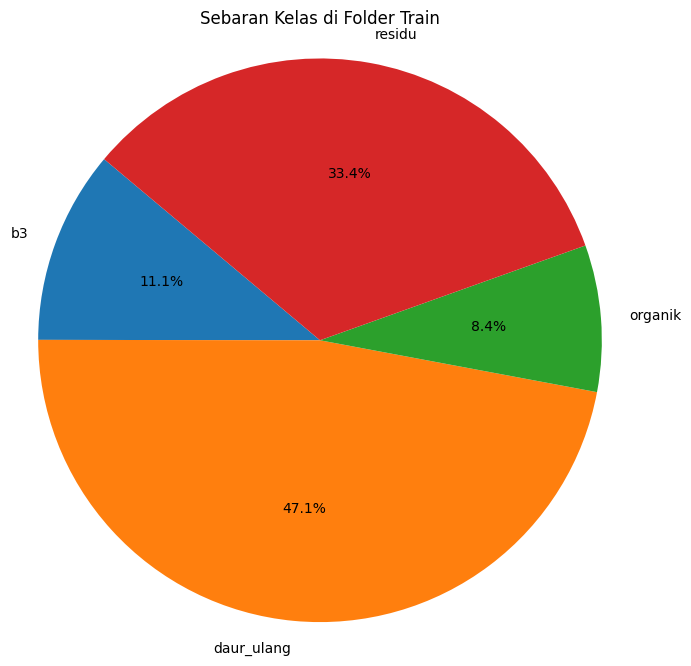

In [13]:
train_dir = 'dataset_split/train'

class_names = sorted(os.listdir(train_dir))  
class_counts = []

for class_name in class_names:
    class_path = os.path.join(train_dir, class_name)
    count = len([f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))])
    class_counts.append(count)

plt.figure(figsize=(8, 8))
plt.pie(class_counts, labels=class_names, autopct='%1.1f%%', startangle=140)
plt.title('Sebaran Kelas di Folder Train')
plt.axis('equal')
plt.show()

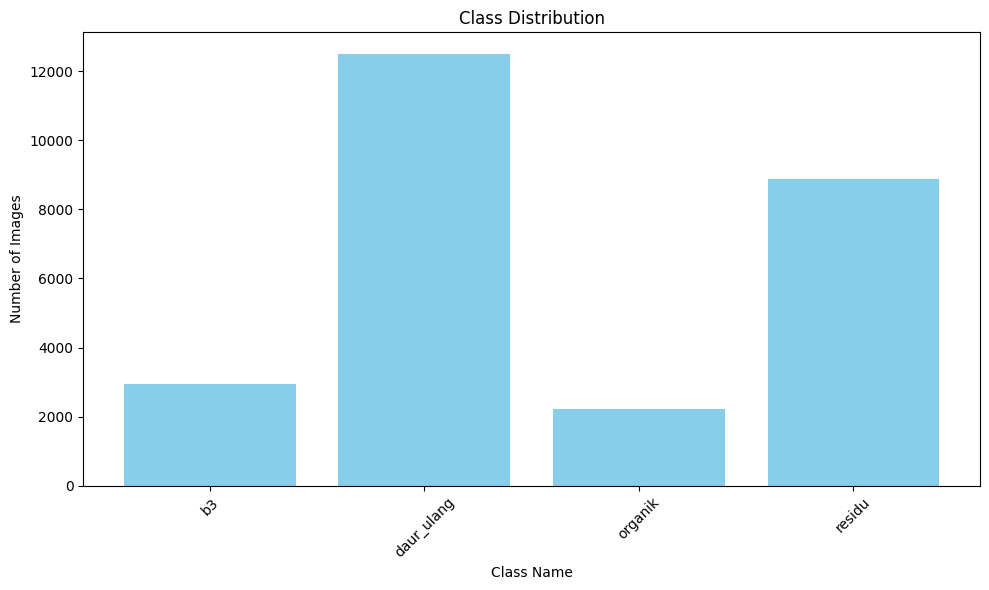

In [14]:
plt.figure(figsize=(10, 6))
plt.bar(class_names, class_counts, color='skyblue')
plt.xlabel('Class Name')
plt.ylabel('Number of Images')
plt.title('Class Distribution')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [15]:
train_dir = os.path.join(target_dir, 'train')

class_counts = {}
for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    class_counts[class_name] = len(os.listdir(class_path))

min_count = min(class_counts.values())

for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    images = os.listdir(class_path)

    if len(images) > min_count:
        random.shuffle(images)
        images_to_keep = images[:min_count]
        images_to_remove = set(images) - set(images_to_keep)

        for img in images_to_remove:
            os.remove(os.path.join(class_path, img))

print("✅ Under sampling selesai pada data latih.")

✅ Under sampling selesai pada data latih.


In [16]:
class_counts = {}
total_count = 0

for class_name in sorted(os.listdir(train_dir)):
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
        count = len([f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))])
        class_counts[class_name] = count
        total_count += count

print("📊 Jumlah gambar per kelas di TRAIN:")
for class_name, count in class_counts.items():
    print(f"  {class_name}: {count} gambar")

print(f"\n🧮 Total gambar di set TRAIN: {total_count} gambar")

📊 Jumlah gambar per kelas di TRAIN:
  b3: 2232 gambar
  daur_ulang: 2232 gambar
  organik: 2232 gambar
  residu: 2232 gambar

🧮 Total gambar di set TRAIN: 8928 gambar


In [17]:
base_dir = 'dataset_split'
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    fill_mode='nearest'
)

train_gen = train_datagen.flow_from_directory(
    os.path.join(base_dir, 'train'),
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

test_datagen = ImageDataGenerator(rescale=1./255)
test_gen = test_datagen.flow_from_directory(
    os.path.join(base_dir, 'test'),
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

val_datagen = ImageDataGenerator(rescale=1./255)
val_gen = val_datagen.flow_from_directory(
    os.path.join(base_dir, 'val'),
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

Found 8928 images belonging to 4 classes.
Found 3322 images belonging to 4 classes.
Found 3318 images belonging to 4 classes.


In [19]:
class StopTrainingAtAccuracy(Callback):
    def __init__(self, acc_threshold=0.95, val_acc_threshold=0.95):
        super(StopTrainingAtAccuracy, self).__init__()
        self.acc_threshold = acc_threshold
        self.val_acc_threshold = val_acc_threshold

    def on_epoch_end(self, epoch, logs=None):
        acc = logs.get("accuracy")
        val_acc = logs.get("val_accuracy")
        if acc is not None and val_acc is not None:
            if acc >= self.acc_threshold and val_acc >= self.val_acc_threshold:
                print(f"\n Target tercapai! Akurasi dan val_akurasi >= {self.acc_threshold * 100:.0f}%")
                self.model.stop_training = True

In [20]:
base_model = MobileNetV2(
    input_shape=(150, 150, 3),
    include_top=False,
    weights='imagenet'  
)

base_model.trainable = True

inputs = Input(shape=(150, 150, 3))
x = base_model(inputs, training=False)  
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
outputs = Dense(len(class_names), activation='softmax')(x)

model = Model(inputs, outputs)

model.compile(
    optimizer=Adam(learning_rate=0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

/tmp/ipykernel_35/3448904702.py:7: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(
I0000 00:00:1751780761.238463      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1751780761.239149      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 5, 5, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,422,980 (9.24 MB)

 Trainable params: 2,388,612 (9.11 MB)

 Non-trainable params: 34,368 (134.25 KB)

In [21]:
callback = [
    StopTrainingAtAccuracy(),
    ModelCheckpoint('model_checkpoint.keras', save_best_only=True, verbose=1),
    EarlyStopping(monitor='val_loss', patience=5, verbose=1),
]

history = model.fit(
    train_gen,
    epochs=100,
    validation_data=val_gen,
    callbacks=callback,
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100


I0000 00:00:1751780802.570869     124 service.cc:148] XLA service 0x7f0de4032120 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751780802.572421     124 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1751780802.572443     124 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1751780806.052746     124 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/279 ━━━━━━━━━━━━━━━━━━━━ 20s 75ms/step - accuracy: 0.1953 - loss: 2.4566   

I0000 00:00:1751780824.630030     124 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


279/279 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - accuracy: 0.3570 - loss: 1.9669
Epoch 1: val_loss improved from inf to 0.90995, saving model to model_checkpoint.keras
279/279 ━━━━━━━━━━━━━━━━━━━━ 152s 336ms/step - accuracy: 0.3573 - loss: 1.9658 - val_accuracy: 0.6603 - val_loss: 0.9099
Epoch 2/100
279/279 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - accuracy: 0.6035 - loss: 1.1356
Epoch 2: val_loss improved from 0.90995 to 0.69759, saving model to model_checkpoint.keras
279/279 ━━━━━━━━━━━━━━━━━━━━ 83s 299ms/step - accuracy: 0.6036 - loss: 1.1353 - val_accuracy: 0.7571 - val_loss: 0.6976
Epoch 3/100
279/279 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - accuracy: 0.7139 - loss: 0.8350
Epoch 3: val_loss improved from 0.69759 to 0.57102, saving model to model_checkpoint.keras
279/279 ━━━━━━━━━━━━━━━━━━━━ 82s 294ms/step - accuracy: 0.7140 - loss: 0.8348 - val_accuracy: 0.8014 - val_loss: 0.5710
Epoch 4/100
279/279 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - accuracy: 0.7545 - loss: 0.7182
Epoch 4: val_loss improved

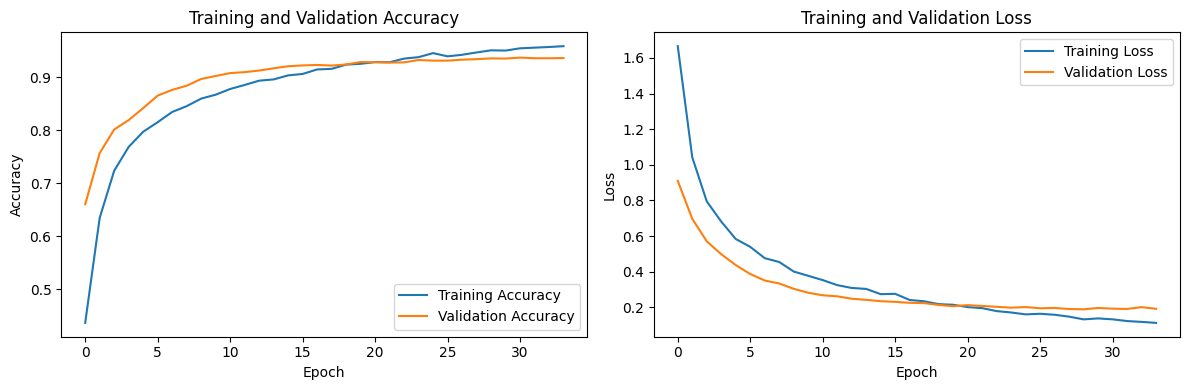

In [22]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [23]:
loss, acc = model.evaluate(test_gen)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {acc:.4f}")

104/104 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - accuracy: 0.9442 - loss: 0.1789
Test Loss: 0.1850, Test Accuracy: 0.9398


In [24]:
test_gen.reset()
pred_probs = model.predict(test_gen, verbose=1)
y_pred = np.argmax(pred_probs, axis=1)
y_true = test_gen.classes

class_labels = list(test_gen.class_indices.keys())

report = classification_report(y_true, y_pred, target_names=class_labels)
print(report)

104/104 ━━━━━━━━━━━━━━━━━━━━ 17s 132ms/step
              precision    recall  f1-score   support

          b3       0.10      0.11      0.10       369
  daur_ulang       0.46      0.46      0.46      1564
     organik       0.06      0.06      0.06       279
      residu       0.32      0.31      0.32      1110

    accuracy                           0.34      3322
   macro avg       0.23      0.23      0.23      3322
weighted avg       0.34      0.34      0.34      3322



In [25]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 2.7 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 25.0
    Uninstalling packaging-25.0:
      Successfully uninstalled packaging-25.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 3.6.0 requires fsspec[http]<=2025.3.0,>=2023.1.0, but you have fsspec 2025.3.2 which is incompatible.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
bigframes 1.42.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.
plotnine 0.14.5 requires matplotlib>=3.8.0, but you have matplotlib 3.7.2 which is incompatible.
pandas-gbq 0.28.0 requires google-api-core<3.0.0dev,>=2.10.2, but you have google-api-core 1.34.1 which is incompatible

In [26]:
model.save("/kaggle/working/my_model.h5")

In [27]:
!tensorflowjs_converter \
    --input_format=keras \
    my_model.h5 \
    tfjs_model/

2025-07-06 06:33:45.401246: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751783625.421525     926 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751783625.428131     926 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
failed to lookup keras version from the file,
    this is likely a weight only file


In [28]:
!zip -r tfjs_model.zip tfjs_model

  adding: tfjs_model/ (stored 0%)
  adding: tfjs_model/model.json (deflated 97%)
  adding: tfjs_model/group1-shard1of3.bin (deflated 7%)
  adding: tfjs_model/group1-shard2of3.bin (deflated 7%)
  adding: tfjs_model/group1-shard3of3.bin (deflated 7%)


In [30]:
pip freeze | cut -d '=' -f 1 > requirements.txt

Note: you may need to restart the kernel to use updated packages.
